-------------------------------------------------------------------------------------------------------------------
Implementation of : "Online Label Recovery for Deep Learning-based communication through Error Correcting codes"

Author : Eric Soubigou

Date : Spring 2019

-------------------------------------------------------------------------------------------------------------------

Description :  Creation of a DFE like with Deep Learning technologies

In [1]:
# Install libraries :
!pip3 install --user git+git://github.com/veeresht/CommPy.git@master
!pip3 install --user torch
!pip3 install --user matplotlib
!pip3 install --user scipy
print("================== DONE ! ==================")

  Cloning git://github.com/veeresht/CommPy.git (to revision master) to /tmp/pip-req-build-gt688dwr
  Stored in directory: /tmp/pip-ephem-wheel-cache-923ei1hu/wheels/d1/6a/31/8ddc70e8eb8a1c3ad344032ed43b4ebfccc41007e8850226d0
Successfully built scikit-commpy
================== DONE ! ==================


In [2]:
## Imports
from __future__ import print_function
import matplotlib.pyplot as plt
import pickle # For saving file
import copy as cpy

# Scipy
import scipy as sp
from scipy import signal

# Numpy
import numpy as np
np.set_printoptions(precision=2)

# Random
import random

# Compy
from commpy.filters import *
import commpy as cp
## Simulation import
from commpy.channelcoding.convcode import Trellis, conv_encode, viterbi_decode
from commpy.modulation import *

# For DL libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set the use of device which will be used 
if torch.cuda.is_available():
    device = torch.device('cuda')
    FloatTensor = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    FloatTensor = torch.FloatTensor


In [ ]:
# Launch simulation
from MonteCarlo import *

simulation_param_dict = {
    "m_c_parameters": {
        "min_error_frame": 100,
        "targeted_fer": 5e-3,
        "step_db": 2,
        "min_eb_n0": 0,
        "max_eb_n0": 40,
    },
    "channel_parameters": {
        "non_lin_coeff": 0,
        "iq_imbalance": None,
        "channel_taps": np.array([1, 2, 3, 2, 1]),
    },
    "frame_length": 256,
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "MMSE",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
}

# Launch the simulation
monte_carlo_simulation(simulation_param_dict)

/home/eric/.local/lib/python3.6/site-packages/commpy/modulation.py:77: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  index_list))


At  0.0  % , BER =  0.46078125 , FER =  1.0  for  Eb/N0 =  0  dB , SNR =  0.0 dB  nb_tries =  100
At  5.0  % , BER =  0.4122265625 , FER =  1.0  for  Eb/N0 =  2  dB , SNR =  2.0 dB  nb_tries =  100
At  10.0  % , BER =  0.3483984375 , FER =  1.0  for  Eb/N0 =  4  dB , SNR =  4.0 dB  nb_tries =  100
At  15.0  % , BER =  0.294765625 , FER =  1.0  for  Eb/N0 =  6  dB , SNR =  6.0 dB  nb_tries =  100
At  20.0  % , BER =  0.24828125 , FER =  1.0  for  Eb/N0 =  8  dB , SNR =  8.0 dB  nb_tries =  100
At  25.0  % , BER =  0.2148828125 , FER =  1.0  for  Eb/N0 =  10  dB , SNR =  10.0 dB  nb_tries =  100
At  30.0  % , BER =  0.164453125 , FER =  1.0  for  Eb/N0 =  12  dB , SNR =  12.0 dB  nb_tries =  100
At  35.0  % , BER =  0.1091796875 , FER =  1.0  for  Eb/N0 =  14  dB , SNR =  14.0 dB  nb_tries =  100
At  40.0  % , BER =  0.0764453125 , FER =  1.0  for  Eb/N0 =  16  dB , SNR =  16.0 dB  nb_tries =  100
At  45.0  % , BER =  0.0560546875 , FER =  1.0  for  Eb/N0 =  18  dB , SNR =  18.0 dB  nb_t

[4.57e-01 4.07e-01 3.42e-01 2.95e-01 2.58e-01 2.14e-01 1.63e-01 1.14e-01
 7.56e-02 5.46e-02 3.57e-02 2.52e-02 1.66e-02 1.02e-02 7.36e-03 4.52e-03
 1.44e-03 7.73e-05 1.95e-07 0.00e+00]


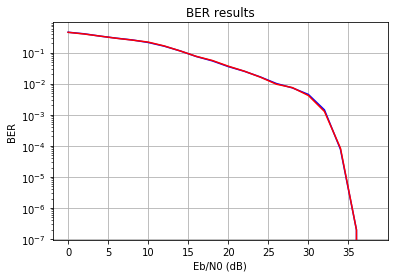

In [5]:
# Print of performances
from Utils import *


res = load_results("./results/OFDM_eq_MMSE_non_lin_coeff_0_iq_im_None_snr_0_to_40_step_2.pickle")
res_ZF = load_results("./results/OFDM_eq_ZF_non_lin_coeff_0_iq_im_None_snr_0_to_40_step_2.pickle")

print(res["results"]["ber"])

plt.plot(res["results"]["eb_n0_db"], res["results"]["ber"], "b")
plt.plot(res_ZF["results"]["eb_n0_db"], res_ZF["results"]["ber"], "r")
plt.yscale("log")
plt.title("BER results")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(True)
plt.show()


In [ ]:
# Data set Creation
data_set_generation_param_dict = {
    "eb_n0_db": 10,
    "channel_parameters": {
        "non_lin_coeff": 0,
        "iq_imbalance": None,
        "channel_taps": np.array([1, 2, 3, 2, 1]),
    },
    "frame_length": 100000,
    "modulation": {
        "modulation_order": 4,
        "nb_carriers": 64,
        "cp_length": 8,
        "off_carrier": 0,
    },
    "equalizer": "MMSE",
    "channel_coding": {
        "mem_size": np.array([2]),
        "g_matrix": np.array([[0o5, 0o7]]),
        "rho": 1 / 2,  #  Coding rate
    },
}

create_data_set(data_set_generation_param_dict)

#########
# Load the data set using the Dataset class
data_set = OFDMSamplesDataset("./data_set/OFDM_non_lin_coeff_0_iq_im_None_eb_n0_10_proakis_C.pt")

print(data_set.get_dimensions())


In [ ]:
# Train the NN-prequlizer
from PreEqualizer import *



